In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from sklearn.metrics import roc_curve, auc

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data

In [14]:
def parse_classification_report(filepath):
    """Parse sklearn classification report CSV."""
    df = pd.read_csv(filepath)
    # Row index 2 (0-based) contains macro avg or overall accuracy
    # Row index 3 contains weighted avg
    # We'll use weighted avg (row 3) for overall performance
    if len(df) >= 4:
        return {
            'precision': df.iloc[3]['precision'],
            'recall': df.iloc[3]['recall'],
            'f1-score': df.iloc[3]['f1-score']
        }
    return None

def load_results(base_path, pattern, model_type):
    """Load all results for a given model type and pattern."""
    results = []
    base = Path(base_path)
    
    for threshold in [0.3, 0.5, 0.7]:
        for seed in [6, 16, 26]:
            filename = pattern.format(threshold=threshold, seed=seed)
            filepath = base / filename
            
            if filepath.exists():
                metrics = parse_classification_report(filepath)
                if metrics:
                    results.append({
                        'model': model_type,
                        'threshold': threshold,
                        'seed': seed,
                        **metrics
                    })
            else:
                print(f"Warning: {filepath} not found")
    
    return results

In [15]:
# Load original models
original_results = load_results(
    '../vgg19_testing',
    'TNsep_{threshold}_s{seed}_report.csv',
    'Original'
)

# Load ablation models
fp_duration_results = load_results(
    './vgg19_testing',
    'fp_duration_{threshold}_s{seed}_report.csv',
    'fp_duration'
)

fp_zoom_results = load_results(
    './vgg19_testing',
    'fp_zoom_{threshold}_s{seed}_report.csv',
    'fp_zoom'
)

fp_no_weight_results = load_results(
    './vgg19_testing',
    'fp_no_weight_{threshold}_s{seed}_report.csv',
    'fp_no_weight'
)

# Combine all results
all_results = original_results + fp_duration_results + fp_zoom_results + fp_no_weight_results
df = pd.DataFrame(all_results)

print(f"Total results loaded: {len(df)}")
print(f"\nResults per model:")
print(df.groupby('model').size())
df.head(10)

Total results loaded: 36

Results per model:
model
Original        9
fp_duration     9
fp_no_weight    9
fp_zoom         9
dtype: int64


,model,threshold,seed,precision,recall,f1-score
0,Original,0.3,6,0.852773,0.85146,0.851322
1,Original,0.3,16,0.882738,0.88078,0.880627
2,Original,0.3,26,0.891862,0.88715,0.886810
3,Original,0.5,6,0.846097,0.84343,0.843128
4,Original,0.5,16,0.868997,0.86075,0.859968
5,Original,0.5,26,0.859231,0.83234,0.829143
6,Original,0.7,6,0.869818,0.85303,0.851343
7,Original,0.7,16,0.850106,0.81090,0.805453
8,Original,0.7,26,0.819045,0.78508,0.779204
9,fp_duration,0.3,6,0.813054,0.81304,0.813038


## 2. Summary Statistics

In [16]:
# Calculate mean and std for each model and threshold
summary = df.groupby(['model', 'threshold']).agg({
    'precision': ['mean', 'std', 'sem'],
    'recall': ['mean', 'std', 'sem'],
    'f1-score': ['mean', 'std', 'sem']
})

# Calculate 95% CI (1.96 * SEM)
summary_flat = summary.copy()
summary_flat.columns = ['_'.join(col).strip() for col in summary_flat.columns.values]
summary_flat

precision_mean  precision_std  precision_sem  \
model        threshold                                                 
Original     0.3              0.875791       0.020450       0.011807   
             0.5              0.858108       0.011491       0.006635   
             0.7              0.846323       0.025597       0.014778   
fp_duration  0.3              0.804306       0.016726       0.009657   
             0.5              0.839700       0.028658       0.016545   
             0.7              0.864573       0.010833       0.006254   
fp_no_weight 0.3              0.795604       0.032697       0.018878   
             0.5              0.808225       0.021355       0.012329   
             0.7              0.862380       0.011609       0.006702   
fp_zoom      0.3              0.855272       0.019734       0.011394   
             0.5              0.850075       0.022553       0.013021   
             0.7              0.848235       0.021414       0.012363   

                        recall_mean  recall_std  recall_sem  f1-score_mean  \
model        threshold                                                       
Original     0.3           0.873130    0.019035    0.010990       0.872920   
             0.5           0.845507    0.014318    0.008267       0.844079   
             0.7           0.816337    0.034300    0.019803       0.812000   
fp_duration  0.3           0.803430    0.018119    0.010461       0.803265   
             0.5           0.831693    0.029207    0.016863       0.830670   
             0.7           0.846630    0.022228    0.012834       0.844562   
fp_no_weight 0.3           0.785280    0.032762    0.018915       0.783346   
             0.5           0.795337    0.024421    0.014100       0.793087   
             0.7           0.845913    0.023871    0.013782       0.843956   
fp_zoom      0.3           0.850937    0.020649    0.011922       0.850465   
             0.5           0.832620    0.045116    0.026047       0.829778   
             0.7           0.811630    0.042773    0.024695       0.805873   

                        f1-score_std  f1-score_sem  
model        threshold                              
Original     0.3            0.018958      0.010945  
             0.5            0.015435      0.008911  
             0.7            0.036513      0.021081  
fp_duration  0.3            0.018388      0.010616  
             0.5            0.029523      0.017045  
             0.7            0.023753      0.013714  
fp_no_weight 0.3            0.033324      0.019239  
             0.5            0.025385      0.014656  
             0.7            0.025706      0.014842  
fp_zoom      0.3            0.020822      0.012022  
             0.5            0.049324      0.028477  
             0.7            0.047019      0.027146

## 3. Performance Comparison Plots

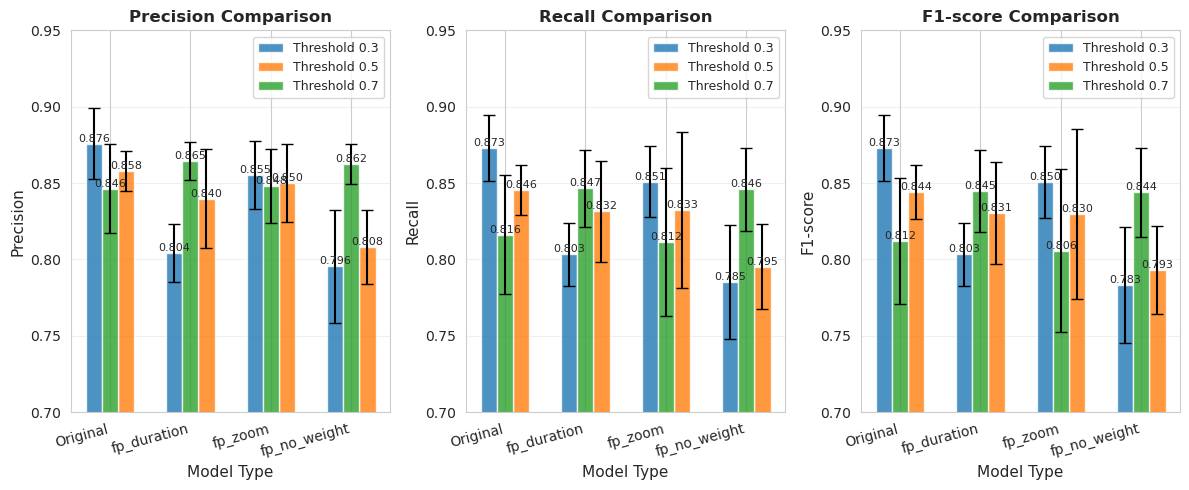

In [17]:
# Prepare data for plotting
metrics = ['precision', 'recall', 'f1-score']
model_order = ['Original', 'fp_duration', 'fp_zoom', 'fp_no_weight']

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Prepare data for each threshold
    for threshold in [0.3, 0.5, 0.7]:
        subset = df[df['threshold'] == threshold]
        means = subset.groupby('model')[metric].mean().reindex(model_order)
        sems = subset.groupby('model')[metric].sem().reindex(model_order)
        ci95 = sems * 1.96
        
        x_pos = np.arange(len(model_order))
        offset = 0.2 if threshold == 0.5 else (-0.2 if threshold == 0.3 else 0)
        
        bars = ax.bar(x_pos + offset, means, width=0.2, 
                     yerr=ci95, capsize=4,
                     label=f'Threshold {threshold}',
                     alpha=0.8)

        # Add value labels
        for i, (bar, mean_val) in enumerate(zip(bars, means)):
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{mean_val:.3f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Model Type', fontsize=11)
    ax.set_ylabel(metric.capitalize(), fontsize=11)
    ax.set_title(f'{metric.capitalize()} Comparison', fontsize=12, fontweight='bold')
    ax.set_xticks(np.arange(len(model_order)))
    ax.set_xticklabels(model_order, rotation=15, ha='right')
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.7, 0.95])

plt.tight_layout()
plt.show()

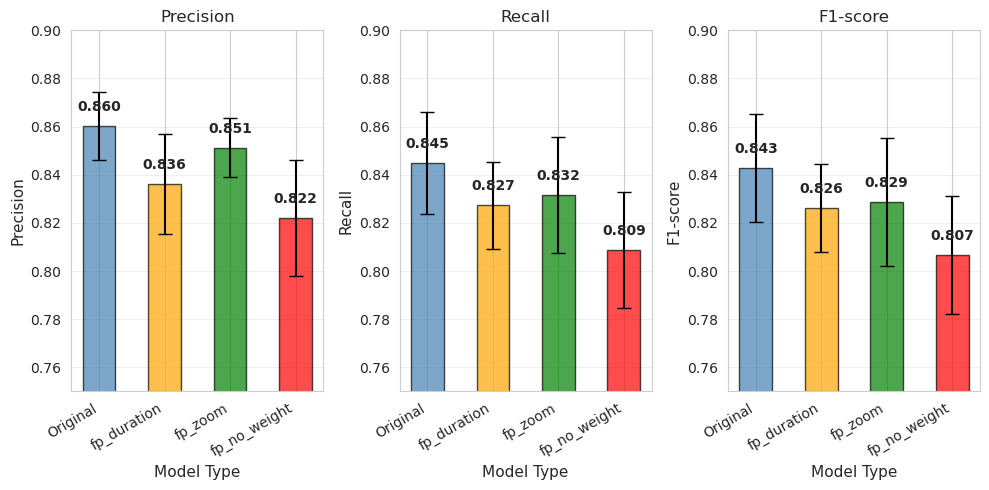

In [18]:
# Performance metrics averaged across thresholds
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

metrics = ['precision', 'recall', 'f1-score']
colors = ['steelblue', 'orange', 'green', 'red']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    x_pos = np.arange(len(model_order))
    
    # Calculate mean and SEM across all seeds and both thresholds
    means = df.groupby('model')[metric].mean().reindex(model_order)
    sems = df.groupby('model')[metric].sem().reindex(model_order)
    ci95 = sems * 1.96
    
    bars = ax.bar(x_pos, means, width=0.5, yerr=ci95, capsize=5,
                  color=colors, alpha=0.7, edgecolor='black')
    
    # Add value labels
    for bar, mean_val in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
               f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Model Type', fontsize=11)
    ax.set_ylabel(metric.capitalize(), fontsize=11)
    ax.set_title(f'{metric.capitalize()}', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_order, rotation=30, ha='right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.75, 0.9])

plt.tight_layout()
plt.show()

## 4. F1-Score Focus Plot

/tmp/ipykernel_2401982/1033457524.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_order, rotation=15, ha='right')
/tmp/ipykernel_2401982/1033457524.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_order, rotation=15, ha='right')
/tmp/ipykernel_2401982/1033457524.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(model_order, rotation=15, ha='right')


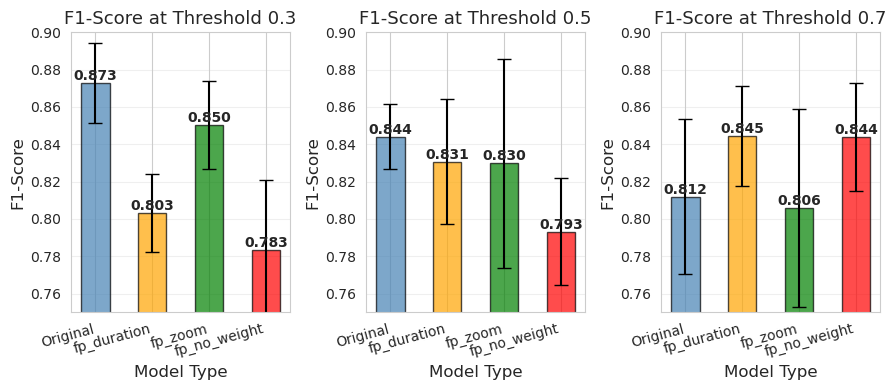

In [19]:
# Detailed F1-score comparison
fig, axes = plt.subplots(1, 3, figsize=(9, 4))

for idx, threshold in enumerate([0.3, 0.5, 0.7]):
    ax = axes[idx]
    subset = df[df['threshold'] == threshold]
    
    means = subset.groupby('model')['f1-score'].mean().reindex(model_order)
    sems = subset.groupby('model')['f1-score'].sem().reindex(model_order)
    ci95 = sems * 1.96
    
    colors = ['steelblue', 'orange', 'green', 'red']
    bars = ax.bar(model_order, means, yerr=ci95, capsize=5, 
                  color=colors, alpha=0.7, edgecolor='black', width=0.5)
    
    # Add value labels
    for bar, mean_val in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
               f'{mean_val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel('Model Type', fontsize=12)
    ax.set_ylabel('F1-Score', fontsize=12)
    ax.set_title(f'F1-Score at Threshold {threshold}', fontsize=13)
    ax.set_xticklabels(model_order, rotation=15, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.75, 0.9])

plt.tight_layout()
plt.show()

## 5. ROC Curve and AUC Analysis

In [20]:
def load_predictions(base_path, pattern, is_gt=False):
    """Load predictions from test CSV files and aggregate all predictions."""
    all_yhats = []
    all_ytruths = []
    base = Path(base_path)
    
    threshold_values = [0.3, 0.5, 0.7]

    for threshold in threshold_values:
        for seed in [6, 16, 26]:
            filename = pattern.format(threshold=threshold, seed=seed)
            filepath = base / filename
            
            if filepath.exists():
                pred_df = pd.read_csv(filepath)
                all_yhats.extend(pred_df['yhat'].values)
                all_ytruths.extend(pred_df['ytruth'].values)
            else:
                print(f"Warning: {filepath} not found")
    
    return np.array(all_yhats), np.array(all_ytruths)

# Load predictions for each model type
models_predictions = {}

# Original model
yhats, ytruths = load_predictions(
    '../vgg19_testing',
    'TNsep_{threshold}_s{seed}_test.csv',
    is_gt=False
)
models_predictions['Original'] = (yhats, ytruths)

# Ablation models
ablation_models = [
    ('fp_duration', 'fp_duration_{threshold}_s{seed}_test.csv'),
    ('fp_zoom', 'fp_zoom_{threshold}_s{seed}_test.csv'),
    ('fp_no_weight', 'fp_no_weight_{threshold}_s{seed}_test.csv')
]

for model_name, pattern in ablation_models:
    yhats, ytruths = load_predictions('./vgg19_testing', pattern)
    models_predictions[model_name] = (yhats, ytruths)

# Display statistics
print("Predictions loaded:")
for model_name, (yhats, ytruths) in models_predictions.items():
    print(f"{model_name}: {len(yhats)} predictions (from 9 cases combined)")

Predictions loaded:
Original: 900000 predictions (from 9 cases combined)
fp_duration: 900000 predictions (from 9 cases combined)
fp_zoom: 900000 predictions (from 9 cases combined)
fp_no_weight: 900000 predictions (from 9 cases combined)


Original: AUC = 0.9041
fp_duration: AUC = 0.8917
fp_zoom: AUC = 0.9193
fp_no_weight: AUC = 0.8738


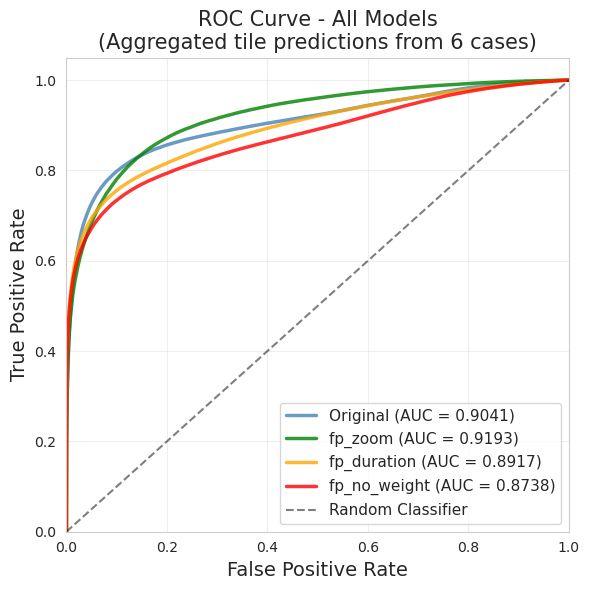


ROC AUC Summary (Aggregated across 6 cases)
Original       : 0.9041
fp_zoom        : 0.9193
fp_duration    : 0.8917
fp_no_weight   : 0.8738


In [21]:
# Calculate ROC curve and AUC for each model
# For each model: all predictions from 6 cases (threshold 0.3/0.5 × seed 6/16/26) are combined
# This gives one ROC curve per model based on ~600k aggregated tile predictions
roc_results = {}

for model_name, (yhats, ytruths) in models_predictions.items():
    fpr, tpr, thresholds = roc_curve(ytruths, yhats)
    roc_auc = auc(fpr, tpr)
    roc_results[model_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }
    print(f"{model_name}: AUC = {roc_auc:.4f}")

# Plot single ROC curve with all models
plt.figure(figsize=(6, 6))

colors = {'Original': 'steelblue', 'fp_duration': 'orange', 'fp_zoom': 'green', 'fp_no_weight': 'red'}
model_order = ['Original', 'fp_zoom',  'fp_duration', 'fp_no_weight']

for model_name in model_order:
    result = roc_results[model_name]
    plt.plot(result['fpr'], result['tpr'], 
             label=f"{model_name} (AUC = {result['auc']:.4f})",
             color=colors[model_name], linewidth=2.5, alpha=0.8)

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve - All Models\n(Aggregated tile predictions from 6 cases)', fontsize=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print AUC summary
print("\n" + "="*50)
print("ROC AUC Summary (Aggregated across 6 cases)")
print("="*50)
for model_name in model_order:
    print(f"{model_name:15s}: {roc_results[model_name]['auc']:.4f}")

Predictions by case loaded successfully
Cases per model: 9
Original: Voting complete - 100000 samples
fp_duration: Voting complete - 100000 samples
fp_zoom: Voting complete - 100000 samples
fp_no_weight: Voting complete - 100000 samples
Original (Majority Vote): AUC = 0.9394
fp_duration (Majority Vote): AUC = 0.9260
fp_zoom (Majority Vote): AUC = 0.9416
fp_no_weight (Majority Vote): AUC = 0.9279


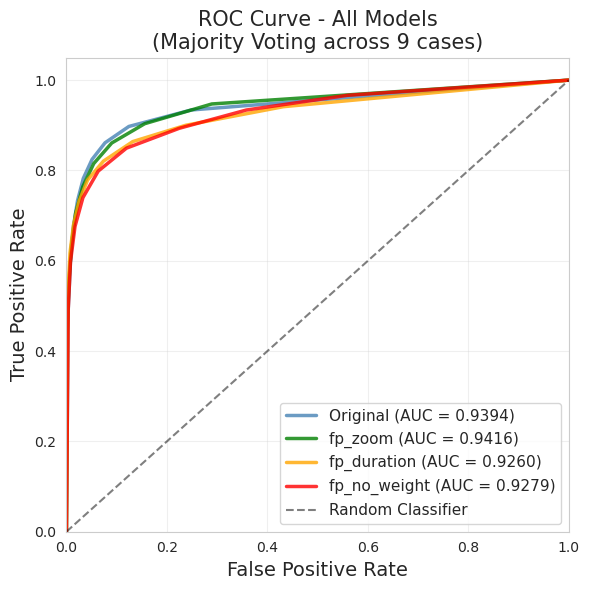


ROC AUC Comparison: Aggregation vs Majority Voting
Model           Aggregation  Voting       Difference  
------------------------------------------------------------
Original        0.9041       0.9394       +0.0352
fp_zoom         0.9193       0.9416       +0.0223
fp_duration     0.8917       0.9260       +0.0344
fp_no_weight    0.8738       0.9279       +0.0541


In [22]:
def load_predictions_by_case(base_path, pattern, model_type):
    """Load predictions separately for each case (threshold + seed combination)."""
    predictions_by_case = {}
    base = Path(base_path)
    
    for threshold in [0.3, 0.5, 0.7]:
        for seed in [6, 16, 26]:
            filename = pattern.format(threshold=threshold, seed=seed)
            filepath = base / filename
            
            if filepath.exists():
                pred_df = pd.read_csv(filepath)
                case_key = f"t{threshold}_s{seed}"
                predictions_by_case[case_key] = pred_df
            else:
                print(f"Warning: {filepath} not found")
    
    return predictions_by_case

# Load predictions by case for each model
models_by_case = {}

# Original model
preds_by_case = load_predictions_by_case(
    '../vgg19_testing',
    'TNsep_{threshold}_s{seed}_test.csv',
    'Original'
)
models_by_case['Original'] = preds_by_case

# Ablation models
ablation_models = [
    ('fp_duration', 'fp_duration_{threshold}_s{seed}_test.csv'),
    ('fp_zoom', 'fp_zoom_{threshold}_s{seed}_test.csv'),
    ('fp_no_weight', 'fp_no_weight_{threshold}_s{seed}_test.csv')
]

for model_name, pattern in ablation_models:
    preds_by_case = load_predictions_by_case('./vgg19_testing', pattern, model_name)
    models_by_case[model_name] = preds_by_case

print("Predictions by case loaded successfully")
print(f"Cases per model: {len(list(models_by_case.values())[0])}")

# Perform majority voting across 6 cases
def majority_vote_predictions(preds_by_case):
    """
    Perform majority voting on predictions from 6 cases.
    For each tile, convert probability to binary prediction (>0.5) and take majority vote.
    Returns voted predictions (as probabilities: proportion of votes for class 1).
    """
    # Get all case keys
    case_keys = sorted(preds_by_case.keys())
    
    # Assume all cases have same number of samples and same order
    n_samples = len(preds_by_case[case_keys[0]])
    
    # Stack predictions from all cases
    all_preds = np.zeros((n_samples, len(case_keys)))
    
    for i, case_key in enumerate(case_keys):
        # Convert probabilities to binary predictions (threshold 0.5)
        all_preds[:, i] = (preds_by_case[case_key]['yhat'].values > 0.5).astype(int)
    
    # Majority vote: proportion of models predicting class 1
    voted_probs = all_preds.mean(axis=1)
    
    # Get ground truth from first case (should be same for all)
    ytruths = preds_by_case[case_keys[0]]['ytruth'].values
    
    return voted_probs, ytruths

# Apply majority voting for each model
voted_predictions = {}

for model_name, preds_by_case in models_by_case.items():
    voted_probs, ytruths = majority_vote_predictions(preds_by_case)
    voted_predictions[model_name] = (voted_probs, ytruths)
    print(f"{model_name}: Voting complete - {len(voted_probs)} samples")

# Calculate ROC curves for majority voted predictions
voted_roc_results = {}

for model_name, (voted_probs, ytruths) in voted_predictions.items():
    fpr, tpr, thresholds = roc_curve(ytruths, voted_probs)
    roc_auc = auc(fpr, tpr)
    voted_roc_results[model_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }
    print(f"{model_name} (Majority Vote): AUC = {roc_auc:.4f}")

# Plot ROC curve for majority voting
plt.figure(figsize=(6, 6))

colors = {'Original': 'steelblue', 'fp_duration': 'orange', 'fp_zoom': 'green', 'fp_no_weight': 'red'}
model_order = ['Original', 'fp_zoom',  'fp_duration', 'fp_no_weight']

for model_name in model_order:
    result = voted_roc_results[model_name]
    plt.plot(result['fpr'], result['tpr'], 
             label=f"{model_name} (AUC = {result['auc']:.4f})",
             color=colors[model_name], linewidth=2.5, alpha=0.8)

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve - All Models\n(Majority Voting across 9 cases)', fontsize=15)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print comparison of aggregation vs voting
print("\n" + "="*60)
print("ROC AUC Comparison: Aggregation vs Majority Voting")
print("="*60)
print(f"{'Model':<15} {'Aggregation':<12} {'Voting':<12} {'Difference':<12}")
print("-"*60)
for model_name in model_order:
    agg_auc = roc_results[model_name]['auc']
    vote_auc = voted_roc_results[model_name]['auc']
    diff = vote_auc - agg_auc
    print(f"{model_name:<15} {agg_auc:.4f}       {vote_auc:.4f}       {diff:+.4f}")

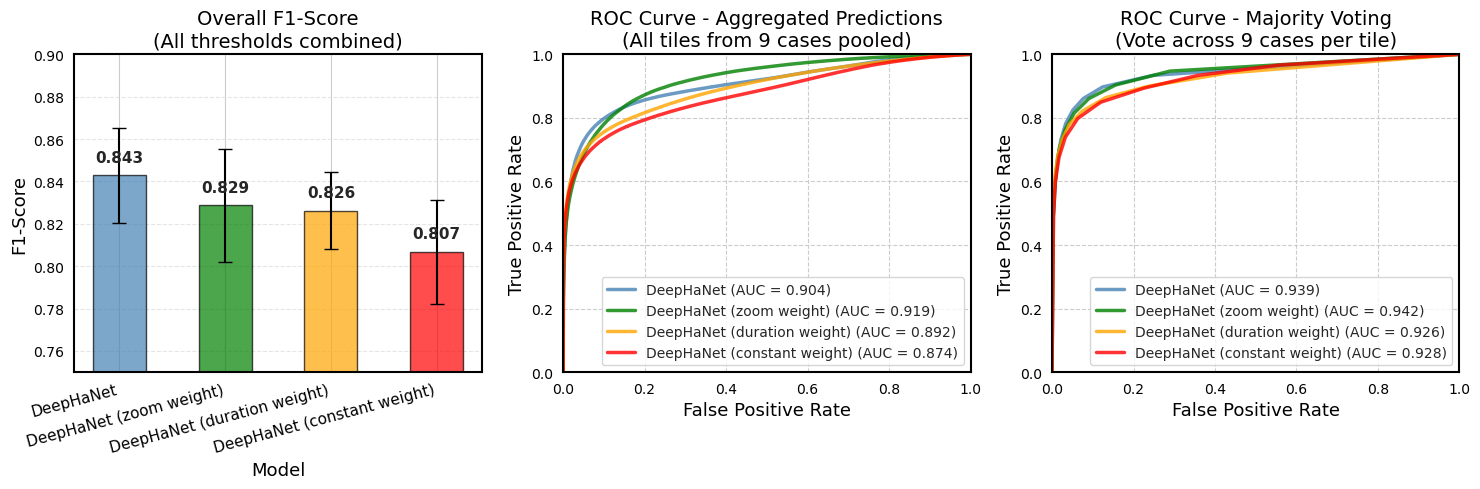


ROC AUC Comparison: Aggregation vs Majority Voting
Model           Aggregation    Voting         Difference  
-----------------------------------------------------------------
Original        0.9041         0.9394         +0.0352
fp_zoom         0.9193         0.9416         +0.0223
fp_duration     0.8917         0.9260         +0.0344
fp_no_weight    0.8738         0.9279         +0.0541

Overall F1-Score (All thresholds combined)
DeepHaNet                 0.8430 ± 0.0224
DeepHaNet (zoom weight)   0.8287 ± 0.0265
DeepHaNet (duration weight) 0.8262 ± 0.0182
DeepHaNet (constant weight) 0.8068 ± 0.0244


In [ ]:
# Plot both ROC curves side by side with F1-score comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

colors = {'Original': 'steelblue', 'fp_duration': 'orange', 'fp_zoom': 'green', 'fp_no_weight': 'red'}
model_order = ['Original', 'fp_zoom', 'fp_duration', 'fp_no_weight']
model_labels = {'Original': 'DeepHaNet', 'fp_zoom': 'DeepHaNet (zoom-weight)', 'fp_duration': 'DeepHaNet (duration-weight)', 'fp_no_weight': 'DeepHaNet (constant-weight)'}

# Left plot: Overall F1-scores (averaged across all thresholds)
ax1 = axes[0]
x_pos = np.arange(len(model_order))

# Calculate mean F1-score across all thresholds and seeds
means = df.groupby('model')['f1-score'].mean().reindex(model_order)
sems = df.groupby('model')['f1-score'].sem().reindex(model_order)
ci95 = sems * 1.96

bars = ax1.bar(x_pos, means, width=0.5, yerr=ci95, capsize=5,
               color=[colors[m] for m in model_order], alpha=0.7, edgecolor='black')

# Add value labels
for bar, mean_val in zip(bars, means):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005,
            f'{mean_val:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax1.set_xlabel('Model', fontsize=13, color='black')
ax1.set_ylabel('F1-Score', fontsize=13, color='black')
ax1.set_title('Overall F1-Score\n(All thresholds combined)', fontsize=14, color='black')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([model_labels[m] for m in model_order], rotation=15, ha='right', fontsize=11)
ax1.tick_params(colors='black')
ax1.grid(axis='y', alpha=0.5, linestyle='--')
ax1.set_ylim([0.75, 0.9])
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Middle plot: Aggregated predictions
ax2 = axes[1]
for model_name in model_order:
    result = roc_results[model_name]
    ax2.plot(result['fpr'], result['tpr'], 
             label=f"{model_labels[model_name]} (AUC = {result['auc']:.3f})",
             color=colors[model_name], linewidth=2.5, alpha=0.8)

ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('False Positive Rate', fontsize=13, color='black')
ax2.set_ylabel('True Positive Rate', fontsize=13, color='black')
ax2.set_title('ROC Curve - Aggregated Predictions\n(All tiles from 9 cases pooled)', fontsize=14, color='black')
ax2.legend(loc="lower right", fontsize=10)
ax2.tick_params(colors='black')
ax2.grid(True, alpha=1, linestyle='--')
for spine in ax2.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Right plot: Majority voting
ax3 = axes[2]
for model_name in model_order:
    result = voted_roc_results[model_name]
    ax3.plot(result['fpr'], result['tpr'], 
             label=f"{model_labels[model_name]} (AUC = {result['auc']:.3f})",
             color=colors[model_name], linewidth=2.5, alpha=0.8)

ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.0])
ax3.set_xlabel('False Positive Rate', fontsize=13, color='black')
ax3.set_ylabel('True Positive Rate', fontsize=13, color='black')
ax3.set_title('ROC Curve - Majority Voting\n(Vote across 9 cases per tile)', fontsize=14, color='black')
ax3.legend(loc="lower right", fontsize=10)
ax3.tick_params(colors='black')
ax3.grid(True, alpha=1, linestyle='--')
for spine in ax3.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

plt.tight_layout()
fig.savefig('./results/roc_all_vs_voting_with_f1.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Print side-by-side comparison
print("\n" + "="*65)
print("ROC AUC Comparison: Aggregation vs Majority Voting")
print("="*65)
print(f"{'Model':<15} {'Aggregation':<14} {'Voting':<14} {'Difference':<12}")
print("-"*65)
for model_name in model_order:
    agg_auc = roc_results[model_name]['auc']
    vote_auc = voted_roc_results[model_name]['auc']
    diff = vote_auc - agg_auc
    print(f"{model_name:<15} {agg_auc:.4f}         {vote_auc:.4f}         {diff:+.4f}")

print("\n" + "="*50)
print("Overall F1-Score (All thresholds combined)")
print("="*50)
for model_name in model_order:
    f1_mean = means[model_order.index(model_name)]
    f1_sem = sems[model_order.index(model_name)]
    print(f"{model_labels[model_name]:<25} {f1_mean:.4f} ± {f1_sem*1.96:.4f}")